In [138]:
# Recurrsive multi-step forecast using Linear Algorithms
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import RANSACRegressor, PassiveAggressiveRegressor, SGDRegressor

In [139]:
# Split the dataset with daily observation into Train And Test. Use First three years as train and Last year as test.
# After splitting, restructure into window of weekly data.
# i/p: Dataframe Values, o/p: Train and Test array. Each row contains array of daily data for 1 week.
def split_data_train_test(data):
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train , len(train)/7))
    test = np.array(np.split(test , len(test)/7))
    return train, test

In [140]:
# Prepare a list of ML Linear models as dictionary.
def get_models(models=dict()):
    models['LR'] = LinearRegression()
    models['LA'] = Lasso()
    models['RD'] = Ridge()
    models['ET'] = ElasticNet()
    models['HB'] = HuberRegressor()
    models['LRS'] = Lars()
    models['LLRS'] = LassoLars()
    models['RSR'] = RANSACRegressor()
    models['PAG'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)    
    models['SGD'] = SGDRegressor(max_iter=1000, tol=1e-3)
    return models

In [141]:
# Create a Pipeline for a model with Pre-Processing steps.
def make_pipeline(model):
    steps = []
    steps.append(('standardize', StandardScaler()))
    steps.append(('normalize', MinMaxScaler()))
    steps.append(('model', model))  
    pipeline = Pipeline(steps=steps)
    return pipeline               

In [142]:
# Create evaluation matirx using RMSE across each of the forecasted days and overall score.
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate RMSE score of each day for all the weeks available.
    for col in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, col], predicted[:, col])
        rmse = sqrt(mse)
        scores.append(rmse)
        
    # calculate overall RMSE score of all the weeks available.
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row,col] - predicted[row,col])**2
    score = sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores   

In [143]:
# X = [X1,X2,X3]
# y1 = predict(X)

# X = [X2,X3,y1]
# y2 = predict(X)

# X = [X3,y1,y2]
# y3 = predict(X)
# The model will use the last row of the training dataset to make the forecast called Recursive Multistep Forecast.
def make_forecast(pipeline, weekly_data, n_input):
    weekly_predict = []
    daily_data = [data for data in weekly_data]
    # forecast for next 7 days
    for day in range(7):
        X = (np.array(daily_data[-n_input:])).reshape(1,n_input)
        daily_predict = pipeline.predict(X)[0]
        weekly_predict.append(daily_predict)
        daily_data.append(daily_predict)
    return(weekly_predict)

In [144]:
# i/p: list of weekly data + n_input, o/p: train_x, train_y
def split_train_Xy(history, n_input):
    # Call function to_series to select only Total power
    series = [week[:,0] for week in history] 
    data = np.array(series).flatten()
    X, y = list(), list()
    start = 0
    for i in range(len(data)):
        end = start  + n_input
        if end < len(data):
            X.append(data[start:end])
            y.append(data[end])  
        start += 1    
    return np.array(X), np.array(y)

In [145]:
# Fit a model and make a forecast
# i/p: model, list of weekly data, n_input. o/p: Forecast for next 1 week
def predict_model(model, history, n_input):
    # Call FUNCTION train_test_split
    train_x, train_y = split_train_Xy(history, n_input)
    
    pipeline = make_pipeline(model)
    pipeline.fit(train_x, train_y)
    
    weekly_predict = make_forecast(pipeline, train_x[-1,:], n_input)
    return(weekly_predict)

In [146]:
# Evaluate a single model.
# i/p: Model, Array of train/test and n_input. o/p - Total RMSE and Daily RMSE for 7 days.
def evaluate_model(model, train, test, n_input):
    history = [weekly_data for weekly_data in train]
    predictions = []
    for week in range(len(test)):
        # Call FUNCTION predict_model
        weekly_predict = predict_model(model, history, n_input)
        predictions.append(weekly_predict)
        history.append(test[week,:])
        
    predictions = np.array(predictions)    
    # Call FUNCTION evaluate_forecast
    score, scores = evaluate_forecasts(test[:,:,0], predictions)
    return score, scores    

In [147]:
# Print Scores
def print_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [148]:
# Load a new file with observations of each day, Parse Dates and make it Index.
# This has been created taking SUM of per second observation from actual i/p
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'],
                     index_col='Datetime')

In [149]:
# Split the dataset into train and test.
train, test = split_data_train_test(dataset.values)

In [150]:
# Create the models and set n_input. n_input is the no of prior days model will use for predicting next n_input days.
models = get_models()
n_input = 7

LR: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
LA: [386.838] 403.6, 388.9, 337.3, 371.1, 406.1, 307.6, 471.6
RD: [387.659] 407.9, 388.6, 337.5, 371.2, 407.0, 307.7, 471.7
ET: [469.337] 452.2, 451.9, 435.8, 485.7, 460.4, 405.8, 575.1
HB: [392.465] 412.1, 388.0, 337.9, 377.3, 405.6, 306.9, 492.5
LRS: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
LLRS: [388.406] 396.1, 387.8, 339.3, 377.8, 402.9, 310.3, 481.9
RSR: [465.470] 442.6, 531.4, 412.5, 412.6, 476.1, 426.9, 537.6
PAG: [398.292] 414.5, 390.5, 340.5, 384.8, 408.9, 312.3, 507.3
SGD: [386.858] 404.5, 389.8, 336.5, 370.6, 406.9, 307.8, 470.3


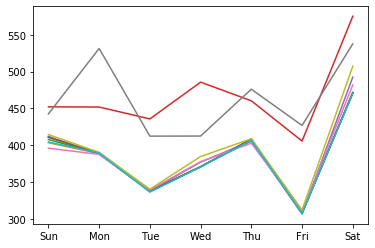

<Figure size 1440x720 with 0 Axes>

In [151]:
# Evaluate each model.
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for name, model in models.items():
    # Call FUNCTION evaluate_model
    score, scores = evaluate_model(model, train, test, n_input)
    # Call FUNCTION print_scores
    print_scores(name, score, scores)
    plt.plot(days, scores, label=name)
plt.figure(figsize=(20,10))
plt.show()